# **AP155 Lab Assignment**
## Module 6: Random Process and Monte Carlo Methods

_Instructions_: Answer each problem as completely as you can. Discuss **all** your answers as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.


### Student Information

_Full Name (Last Name, First Name)_: Tangonan, Darwin James\
_Student No._: 2022 08539\
_Section_: TX3

### Submission Information

_Date and Time Submitted (most recent upload)_: 29 November 2024

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name: DARWIN JAMES JARDINICO TANGONAN**

### Grading Information (c/o Lab Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Problem 1 - []/100

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

### PROBLEM 1

**The Ising model**

_Refer to Exercise 10.9 in the Newman text._ The Ising model is a theoretical model of a magnet. The magnetic potential energy due to the interaction of two dipoles is proportional to their dot product, but in the Ising model this simplifies to just the product $s_i s_j$ for spins on sites $i$ and $j$ of the lattice, since the spins are one-dimensional scalars, not vectors. Then the actual energy of interaction is $-Js_i s_j$, where $J$ is a positive interaction constant. The minus sign ensures that the in- teractions are ferromagnetic, meaning the energy is lower when dipoles are lined up. A ferromagnetic interaction implies that the material will magnetize if given the chance.

Normally it is assumed that spins interact only with those that are immediately adjacent to them on the lattice, which gives a total energy for the entire system equal to
$$ E = -J \sum_{\langle ij \rangle} s_i s_j,$$
where the notation $\langle ij \rangle$ indicates a sum over pairs $i,j$ that are adjacent on the lattice. On the square lattice we use in this exercise each spin has four adjacent neighbors with which it interacts, except for the spins at the edges of the lattice, which have either two or three neighbors.

Perform a Markov chain Monte Carlo simulation of the Ising model on the square lattice for a system of 20 x 20 spins. You will need to set up variables to hold the value ±1 of the spin on each lattice site, probably using a two-dimensional integer array, and then take the following steps.

1. Write a function to calculate the total energy of the system, as given by the equation above. That is, for a given array of values of the spins, go through every pair of adjacent spins and add up the contributions $s_i s_j$ from all of them, then multiply by $-J$. Hint 1: Each unique pair of adjacent spins crops up only once in the sum. Thus there is a term $-Js_1s_2$ if spins 1 and 2 are adjacent to one another, but you do not also need a term $-Js_2s_1$. Hint 2: To make your final program to run in a reasonable amount of time, you will find it helpful if you can work out a way to calculate the energy using Python's ability to do arithmetic with entire arrays at once. If you do the calculation step by step, your program will be significantly slower. *(25 pts.)*

2. Now use your function as the basis for a Metropolis-style simulation of the Ising model with $J = 1$ and temperature $T = 1$ in units where the Boltzmann constant $k_B$ is also 1. Initially set the spin variables randomly to ±1, so that on average about a half of them are up and a half down, giving a total magneti- zation of roughly zero. Then choose a spin at random, flip it, and calculate the new energy after it is flipped, and hence also the change in energy as a result of the flip. Then decide whether to accept the flip using the Metropolis acceptance formula, Eq. (10.60). If the move is rejected you will have to flip the spin back to where it was. Otherwise you keep the flipped spip. Now repeat this process for many moves. *(25 pts.)*

3. Make a plot of the total magnetization $M = \sum_i s_i$ of the system as a function of time for a million Monte Carlo steps. You should see that the system develops a "spontaneous magnetization," a nonzero value of the overall magnetization. Hint: While you are working on your program, do shorter runs, of maybe ten thousand steps at a time. Once you have it working properly, do a longer run of a million steps to get the final results. *(25 pts.)*

4. Run your program several times and observe the sign of the magnetization that develops, positive or negative. Describe what you find and give a brief explana- tion of what is happening. *(25 pts.)*

**Some Prequisite Optimizations**

Before writing and running the python code itself, it is worth noting that with the markov chain algorithm being computationally expensive some optimizations in the logic can be done.

The bulk of the optimization will come from the an optimized calculation of the energy change $\Delta E$, since only one spin cell would be modified, it would be redundant to recalculate the entire grid. Moreover, we also know that the flip would only multiplies the selected term by -1, which can further reduce calculation. The equation would then explicitly reduce to:
$$\begin{align*} 
    \Delta E &= E' - E = -J \sum_{\langle ij \rangle} (s'_i s'_j - s_i s_j) \\
    &= -J \sum_{\langle j \rangle} (s'_{flip} s'_j - s_{flip} s_j) \\
    &= -J \sum_{\langle j \rangle} ((-s_{flip}) s_j - s_{flip} s_j)
    = 2 J s_{flip} \sum_{\langle j \rangle} s_j,
\end{align*} $$
Where $\langle j\rangle$ denotes all terms adjacent to $s_{flip}$.

Another optimization is the calculation of magnetization $M$. As again only one cell is flipped, we can just solve an explicit value of the difference $\Delta M$. An explicit calculation would follow:
$$  \Delta M = M' - M = \sum_i (s'_i - s_i) = s'_{flip} - s_{flip} = s'_{flip} - (-s'_{flip}) = 2s'_{flip}. $$
Lastly, the new magnetization $M'$ would then be obtained as $M' = M + \Delta M$.    

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit              # for faster calculations

# item 1: getting the total energy of the lattice
@njit
def total_energy(spins):
    # -1 and 1 in the indexes to subset and offset arrays, pairing adjacent spins
    
    # Note there are 2 types of pairs:
    E = -np.sum(spins[1:, :] * spins[:-1, :]) # horizontal pairs
    E -= np.sum(spins[:, 1:] * spins[:, :-1]) # vertical pairs
    # The - is due to the -J in the Hamiltonian

    return E

# get the energy difference of a spin flip
@njit
def Energy_diff(spins, L, x, y):
    # when changing a spin, only max 4 neighbors could have contribution to the energy
    adjSpin  = 0 if x == 0   else spins[x - 1, y]  # left
    adjSpin += 0 if x == L-1 else spins[x + 1, y]  # right
    adjSpin += 0 if y == 0   else spins[x, y - 1]  # up
    adjSpin += 0 if y == L-1 else spins[x, y + 1]  # down
    
    # and take the overall dE due to spin flip
    return 2 * spins[x, y] * adjSpin

# item 2: Metropolis-Hastings algorithm
@njit
def metropolis_hastings():
    # Initialize a random initial spin lattice of size LxL 
    L = 20
    spins = np.random.choice(np.array([-1, 1]), (L, L))

    E = total_energy(spins)         # initialize energy
    M = np.sum(spins)               # and magnetization
    
    data = np.zeros((1_000_000, 2))
    for n in range(1_000_000):      # run the simulation for multiple steps
        x = np.random.randint(L)
        y = np.random.randint(L)    # Choose a random spin cell, via x,y coords

        # check whether to accept the flip
        dE = Energy_diff(spins, L, x, y)
        if dE < 0 or np.random.rand() < np.exp(-dE):
            spins[x, y] *= -1       # accept, flip spin,
            E += dE                 # update energy
            M += 2 * spins[x, y]    # and magnetization

        
        data[n] = np.array([M,E])   # record the magnetization data point
    return data                     # return the entire dataset

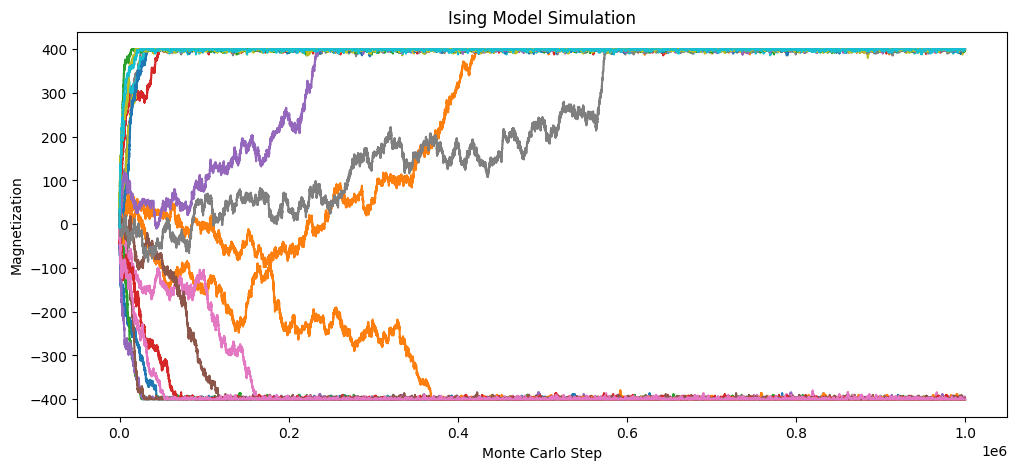

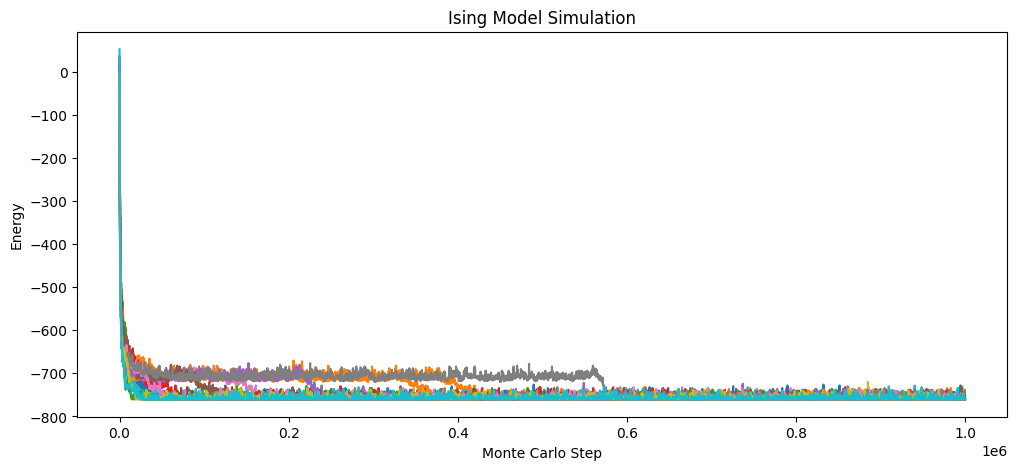

In [50]:
# item 4: repeat the simulation multiple times
data = np.array([metropolis_hastings() for _ in range(20)])
M = data[:, :, 0]
E = data[:, :, 1]

# item 3: plotting the magnetization data
for i in range(20):
    plt.plot(M[i, :])
plt.gcf().set_size_inches(12, 5)
plt.xlabel('Monte Carlo Step')
plt.ylabel('Magnetization')
plt.title('Ising Model Simulation')
plt.show()

for i in range(20):
    plt.plot(E[i, :])
plt.gcf().set_size_inches(12, 5)
plt.xlabel('Monte Carlo Step')
plt.ylabel('Energy')
plt.title('Ising Model Simulation')
plt.show()
    

**Analysis**

The results show a that the magnetization primarily stabilizes to 2 magnetization values of +400, -400. Although markov chains should only stabilize to one equilibrium value, we see more than one value because we are performing a simulation of energy $E$, and not magnetization $M$. 

Moreover, the reason we see two magnetization values is due to the relation of magnetization $M$, energy $E$, and spins $s$. Following the relations defined, energy can be thought of as second order in $s$, while magnetization is 1st order. This is analogous to having a quadratic equation in s for E and a linear equation for M. For every single value of $E$ (representing the minimum equilibrium value) we should get two s values which would then correspond to two M values.

More explicitly, these two equilibrium magnetizations of ±400 correspond to configurations of having all spins up (+1 numerically) or down (-1), taking the sum over a 20x20 lattice would of course give ±1(20x20)=±400. Due to both cases only differing by signs their energy would then be the same being -(±1×±1)×2×(20×19)=-760.

The resulting -760 is verified in the second plot of energy over time.